# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored in 2016 and has seen impressive results in generating new images; you can read the [original paper, here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. These are color images of different classes, such as airplanes, dogs or trucks. This dataset is much more complex and diverse than the MNIST dataset and justifies the use of the DCGAN architecture.

<img src='assets/cifar10_data.png' width=80% />


So, our goal is to create a DCGAN that can generate new, realistic-looking images. We'll go through the following steps to do this:
* **Load in and pre-process the CIFAR10 dataset**
* Define discriminator and generator networks
* **Train these adversarial networks**
* **Visualize the loss over time and some sample, generated images**

In this notebook, we will focus on defining the networks.

#### Deeper Convolutional Networks

Since this dataset is more complex than our MNIST data, we'll need a deeper network to accurately identify patterns in these images and be able to generate new ones. Specifically, we'll use a series of convolutional or transpose convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get these convolutional networks to train. 

Besides these changes in network structure, training the discriminator and generator networks should be the same as before. That is, the discriminator will alternate training on real and fake (generated) images, and the generator will aim to trick the discriminator into thinking that its generated images are real!

In [ ]:
# # run this cell once to install the dependency. 
# You will have to restart the kernel once the package is installed.
!pip install ipywidgets

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

%matplotlib inline

## Getting the data

Here you can download the CIFAR10 dataset. It's a dataset built-in to the PyTorch datasets library. We can load in training data, transform it into Tensor datatypes, then create dataloaders to batch our data into a desired size.

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms

# Tensor transform
transform = transforms.ToTensor()

# CIFAR training datasets
cifar_train = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)

batch_size = 128
num_workers = 4

# build DataLoaders for CIFAR10 dataset
train_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

Files already downloaded and verified


### Visualize the Data

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real, training images that we'll pass to the discriminator. Notice that each image has _one_ associated, numerical label.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if __name__ == '__main__':


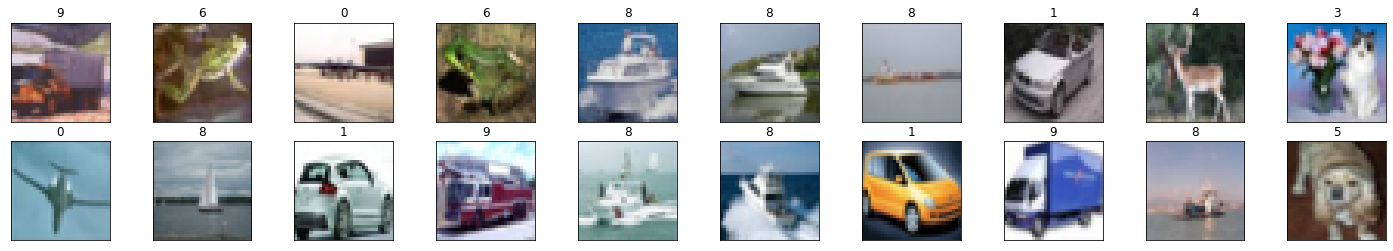

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [4]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.1373)
Max:  tensor(0.9686)


In [5]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_val, max_val = feature_range
    x = x * (max_val - min_val) + min_val
    return x


In [6]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.7255)
Scaled max:  tensor(0.9373)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator. Let's use the models we created in the previous exercise.

## Discriminator

Here you'll build the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. 
* The inputs to the discriminator are 32x32x3 tensor images
* You'll want a few convolutional, hidden layers
* Then a fully connected layer for the output; as before, we want a sigmoid output, but we'll add that in the loss function, [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), later


In [7]:
import torch.nn as nn

In [8]:
class ConvBlock(nn.Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, batch_norm: bool = True):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [9]:
class Discriminator(nn.Module):
    """
    The discriminator model adapted from the DCGAN paper. It should only contains a few layers.
    args:
    - conv_dim: control the number of filters
    """
    def __init__(self, conv_dim: int):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = ConvBlock(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = ConvBlock(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = ConvBlock(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        self.flatten = nn.Flatten()
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten
        x = self.flatten(x)
        # final output layer
        x = self.fc(x)        
        return x

## Generator

Next, you'll build the generator network. The input will be our noise vector `z`, as before. And, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our CIFAR10 images.

In [10]:
class DeconvBlock(nn.Module):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 batch_norm: bool = True):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [11]:
class Generator(nn.Module):
    """
    The generator model adapted from DCGAN
    args:
    - latent_dim: dimension of the latent vector
    - conv_dim: control the number of filters in the convtranspose layers
    """
    def __init__(self, latent_dim: int, conv_dim: int = 32):
        super(Generator, self).__init__()
        # transpose conv layers
        self.deconv1 = DeconvBlock(latent_dim, conv_dim*4, 4, 1, 0)
        self.deconv2 = DeconvBlock(conv_dim*4, conv_dim*2, 4, 2, 1)
        self.deconv3 = DeconvBlock(conv_dim*2, conv_dim, 4, 2, 1)
        self.deconv4 = nn.ConvTranspose2d(conv_dim, 3, 4, stride=2, padding=1)
        self.last_activation = nn.Tanh()
        
    def forward(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.last_activation(x)
        return x
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [12]:
# define hyperparams
conv_dim = 32
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(latent_dim=z_size, conv_dim=conv_dim)

### Training on GPU

Check if you can train on GPU. If you can, set this as a variable and move your models to GPU. 
> Later, we'll also move any inputs our models and loss functions see (real_images, z, and ground truth labels) to GPU as well.

In [13]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
    

GPU available for training. Models moved to GPU


---
## Discriminator and Generator Losses

Now we need to calculate the losses. And this will be exactly the same as before.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the real images with a label = 1, indicating that these are real. The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [14]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

Not much new here, but notice how I am using a small learning rate and custom parameters for the Adam optimizers, This is based on some research into DCGAN model convergence.

### Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [15]:
import torch.optim as optim

# IMPLEMENT BELOW
# params
lr = 0.003 # taken from paper
beta1 = 0.5 # taken from paper
beta2 = 0.999 # default value from Adam optimizer

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=[beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=[beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

**Evaluation mode**

Notice that, when we call our generator to create the samples to display, we set our model to evaluation mode: `G.eval()`. That's so the batch normalization layers will use the population statistics rather than the batch statistics (as they do during training), *and* so dropout layers will operate in eval() mode; not turning off any nodes for generating samples.

In [16]:
import pickle as pkl
from datetime import datetime

In [17]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(14,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()

2024-08-21 17:13:42 | Epoch [1/50] | Batch 0/391 | d_loss: 1.4339 | g_loss: 5.6869
2024-08-21 17:14:21 | Epoch [1/50] | Batch 100/391 | d_loss: 0.3262 | g_loss: 8.6384
2024-08-21 17:14:57 | Epoch [1/50] | Batch 200/391 | d_loss: 0.3264 | g_loss: 8.8002
2024-08-21 17:15:33 | Epoch [1/50] | Batch 300/391 | d_loss: 0.3263 | g_loss: 9.5353


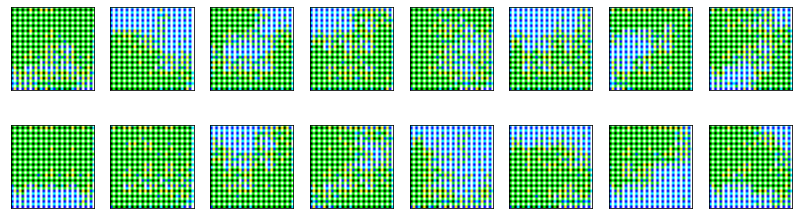

2024-08-21 17:16:10 | Epoch [2/50] | Batch 0/391 | d_loss: 0.3274 | g_loss: 9.9994
2024-08-21 17:16:45 | Epoch [2/50] | Batch 100/391 | d_loss: 0.3260 | g_loss: 10.1793
2024-08-21 17:17:21 | Epoch [2/50] | Batch 200/391 | d_loss: 0.3290 | g_loss: 10.3751
2024-08-21 17:17:58 | Epoch [2/50] | Batch 300/391 | d_loss: 0.3254 | g_loss: 10.4300


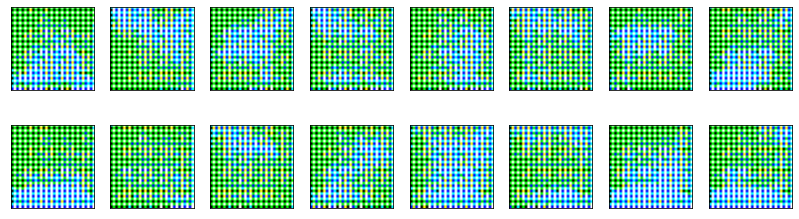

2024-08-21 17:18:35 | Epoch [3/50] | Batch 0/391 | d_loss: 0.3260 | g_loss: 10.5212
2024-08-21 17:19:12 | Epoch [3/50] | Batch 100/391 | d_loss: 0.3282 | g_loss: 10.6642
2024-08-21 17:19:49 | Epoch [3/50] | Batch 200/391 | d_loss: 0.3304 | g_loss: 10.6902
2024-08-21 17:20:25 | Epoch [3/50] | Batch 300/391 | d_loss: 0.3257 | g_loss: 10.7968


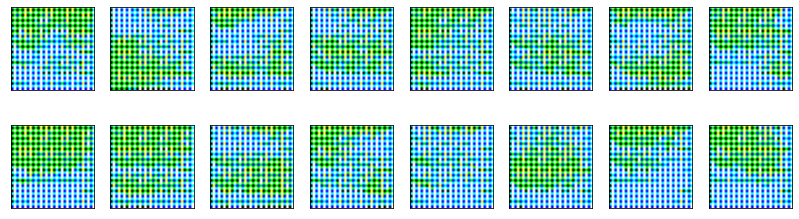

2024-08-21 17:21:01 | Epoch [4/50] | Batch 0/391 | d_loss: 0.3265 | g_loss: 10.7426
2024-08-21 17:21:37 | Epoch [4/50] | Batch 100/391 | d_loss: 0.3255 | g_loss: 10.8428
2024-08-21 17:22:12 | Epoch [4/50] | Batch 200/391 | d_loss: 0.3254 | g_loss: 10.8890
2024-08-21 17:22:48 | Epoch [4/50] | Batch 300/391 | d_loss: 0.3256 | g_loss: 11.0092


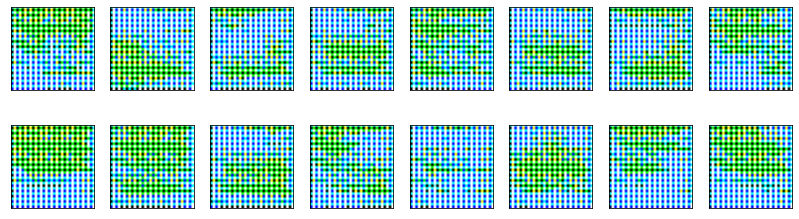

2024-08-21 17:23:28 | Epoch [5/50] | Batch 0/391 | d_loss: 0.3261 | g_loss: 11.0413
2024-08-21 17:24:05 | Epoch [5/50] | Batch 100/391 | d_loss: 0.3263 | g_loss: 11.1674
2024-08-21 17:24:42 | Epoch [5/50] | Batch 200/391 | d_loss: 0.3262 | g_loss: 11.2798
2024-08-21 17:25:21 | Epoch [5/50] | Batch 300/391 | d_loss: 0.3255 | g_loss: 11.1590


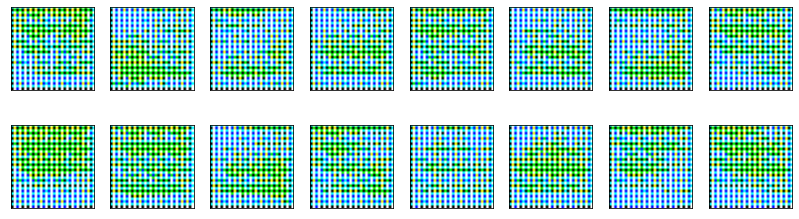

2024-08-21 17:25:59 | Epoch [6/50] | Batch 0/391 | d_loss: 0.3262 | g_loss: 11.2636
2024-08-21 17:26:37 | Epoch [6/50] | Batch 100/391 | d_loss: 0.3264 | g_loss: 11.2432
2024-08-21 17:27:13 | Epoch [6/50] | Batch 200/391 | d_loss: 0.3253 | g_loss: 11.4211
2024-08-21 17:27:50 | Epoch [6/50] | Batch 300/391 | d_loss: 0.3261 | g_loss: 11.4019


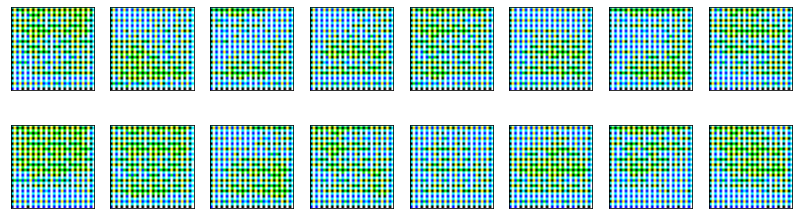

2024-08-21 17:28:29 | Epoch [7/50] | Batch 0/391 | d_loss: 0.3257 | g_loss: 11.3654
2024-08-21 17:29:06 | Epoch [7/50] | Batch 100/391 | d_loss: 0.3263 | g_loss: 11.4205
2024-08-21 17:29:43 | Epoch [7/50] | Batch 200/391 | d_loss: 0.3253 | g_loss: 11.5828
2024-08-21 17:30:19 | Epoch [7/50] | Batch 300/391 | d_loss: 0.3255 | g_loss: 11.6177


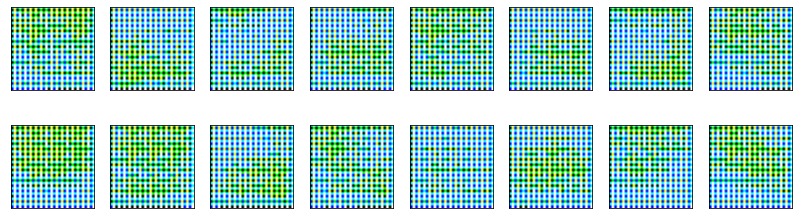

2024-08-21 17:30:57 | Epoch [8/50] | Batch 0/391 | d_loss: 0.3265 | g_loss: 11.6380
2024-08-21 17:31:35 | Epoch [8/50] | Batch 100/391 | d_loss: 0.3255 | g_loss: 11.7382
2024-08-21 17:32:11 | Epoch [8/50] | Batch 200/391 | d_loss: 0.3256 | g_loss: 11.6484
2024-08-21 17:32:47 | Epoch [8/50] | Batch 300/391 | d_loss: 0.3253 | g_loss: 11.6169


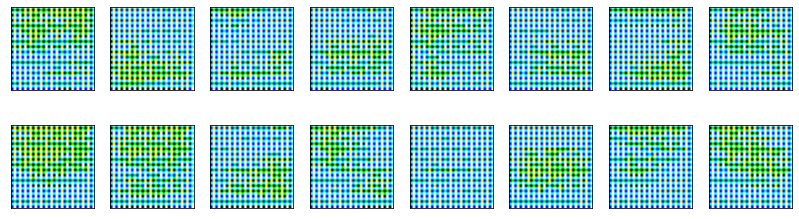

2024-08-21 17:33:24 | Epoch [9/50] | Batch 0/391 | d_loss: 0.3257 | g_loss: 11.8908
2024-08-21 17:33:59 | Epoch [9/50] | Batch 100/391 | d_loss: 0.3252 | g_loss: 11.9031
2024-08-21 17:34:36 | Epoch [9/50] | Batch 200/391 | d_loss: 0.3261 | g_loss: 11.9425
2024-08-21 17:35:14 | Epoch [9/50] | Batch 300/391 | d_loss: 0.3252 | g_loss: 12.0210


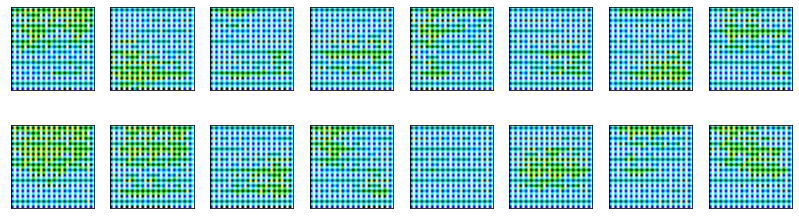

2024-08-21 17:35:53 | Epoch [10/50] | Batch 0/391 | d_loss: 0.3258 | g_loss: 12.1389
2024-08-21 17:36:31 | Epoch [10/50] | Batch 100/391 | d_loss: 0.3253 | g_loss: 12.1747
2024-08-21 17:37:09 | Epoch [10/50] | Batch 200/391 | d_loss: 0.3262 | g_loss: 12.3122
2024-08-21 17:37:45 | Epoch [10/50] | Batch 300/391 | d_loss: 0.3252 | g_loss: 12.2804


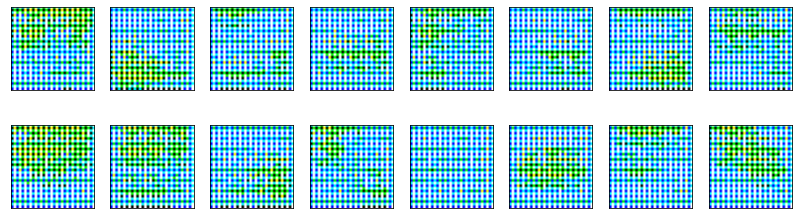

2024-08-21 17:38:21 | Epoch [11/50] | Batch 0/391 | d_loss: 0.3255 | g_loss: 12.2396
2024-08-21 17:38:57 | Epoch [11/50] | Batch 100/391 | d_loss: 0.3257 | g_loss: 12.3319
2024-08-21 17:39:34 | Epoch [11/50] | Batch 200/391 | d_loss: 0.3251 | g_loss: 12.4378
2024-08-21 17:40:10 | Epoch [11/50] | Batch 300/391 | d_loss: 0.3254 | g_loss: 12.4487


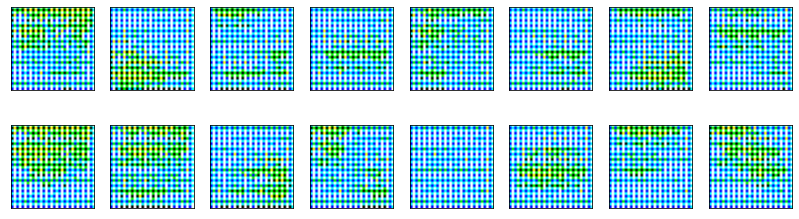

2024-08-21 17:40:49 | Epoch [12/50] | Batch 0/391 | d_loss: 0.3254 | g_loss: 12.4810
2024-08-21 17:41:25 | Epoch [12/50] | Batch 100/391 | d_loss: 0.3252 | g_loss: 12.5039
2024-08-21 17:42:04 | Epoch [12/50] | Batch 200/391 | d_loss: 0.3251 | g_loss: 12.6560
2024-08-21 17:42:40 | Epoch [12/50] | Batch 300/391 | d_loss: 0.3252 | g_loss: 12.7167


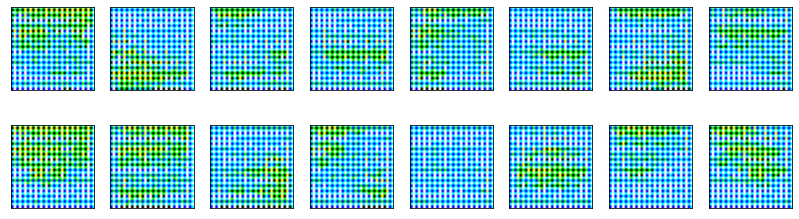

2024-08-21 17:43:20 | Epoch [13/50] | Batch 0/391 | d_loss: 0.3256 | g_loss: 12.7318
2024-08-21 17:43:55 | Epoch [13/50] | Batch 100/391 | d_loss: 0.3254 | g_loss: 12.6803
2024-08-21 17:44:32 | Epoch [13/50] | Batch 200/391 | d_loss: 0.3253 | g_loss: 12.8704
2024-08-21 17:45:09 | Epoch [13/50] | Batch 300/391 | d_loss: 0.3251 | g_loss: 12.8793


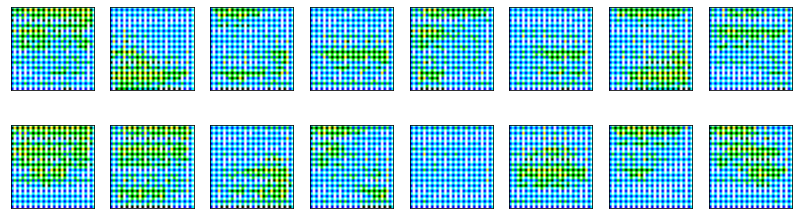

2024-08-21 17:45:46 | Epoch [14/50] | Batch 0/391 | d_loss: 0.3255 | g_loss: 12.9772
2024-08-21 17:46:24 | Epoch [14/50] | Batch 100/391 | d_loss: 0.3258 | g_loss: 12.9504
2024-08-21 17:47:02 | Epoch [14/50] | Batch 200/391 | d_loss: 0.3253 | g_loss: 12.9456
2024-08-21 17:47:40 | Epoch [14/50] | Batch 300/391 | d_loss: 0.3253 | g_loss: 13.0135


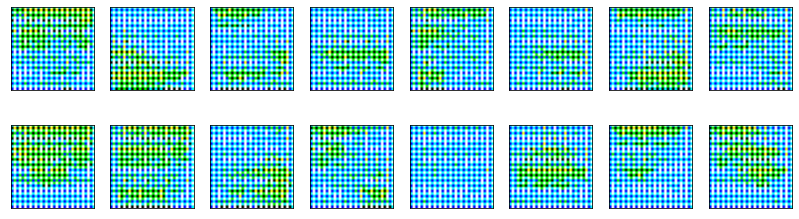

2024-08-21 17:48:16 | Epoch [15/50] | Batch 0/391 | d_loss: 0.3255 | g_loss: 13.0150
2024-08-21 17:48:51 | Epoch [15/50] | Batch 100/391 | d_loss: 0.3251 | g_loss: 13.0649
2024-08-21 17:49:28 | Epoch [15/50] | Batch 200/391 | d_loss: 0.3253 | g_loss: 13.2000
2024-08-21 17:50:03 | Epoch [15/50] | Batch 300/391 | d_loss: 0.3252 | g_loss: 12.9472


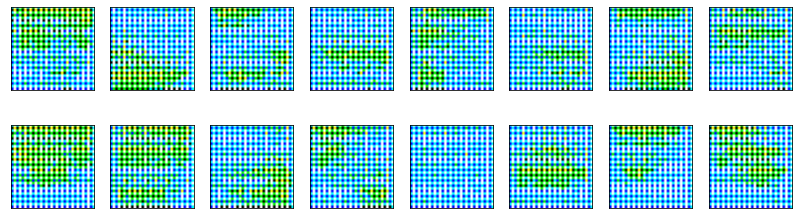

2024-08-21 17:50:41 | Epoch [16/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 13.0783
2024-08-21 17:51:18 | Epoch [16/50] | Batch 100/391 | d_loss: 0.3252 | g_loss: 13.1347
2024-08-21 17:51:55 | Epoch [16/50] | Batch 200/391 | d_loss: 0.3252 | g_loss: 13.1770
2024-08-21 17:52:31 | Epoch [16/50] | Batch 300/391 | d_loss: 0.3252 | g_loss: 13.1807


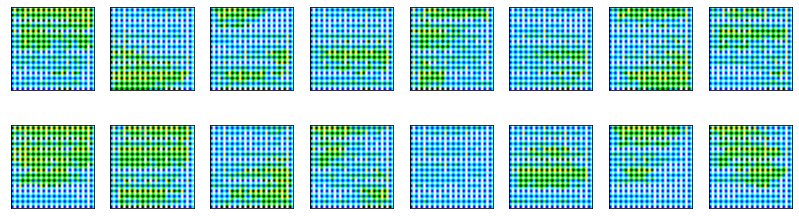

2024-08-21 17:53:09 | Epoch [17/50] | Batch 0/391 | d_loss: 0.3253 | g_loss: 13.1523
2024-08-21 17:53:47 | Epoch [17/50] | Batch 100/391 | d_loss: 0.3252 | g_loss: 13.1427
2024-08-21 17:54:23 | Epoch [17/50] | Batch 200/391 | d_loss: 0.3251 | g_loss: 13.2521
2024-08-21 17:55:01 | Epoch [17/50] | Batch 300/391 | d_loss: 0.3253 | g_loss: 13.2842


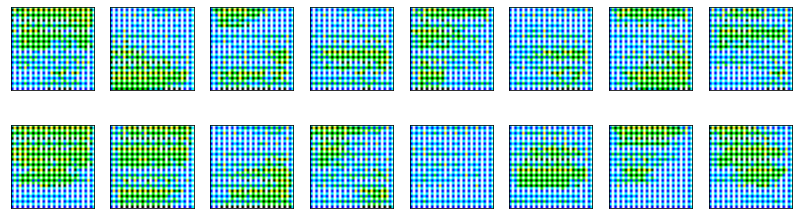

2024-08-21 17:55:38 | Epoch [18/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 13.1631
2024-08-21 17:56:15 | Epoch [18/50] | Batch 100/391 | d_loss: 0.3253 | g_loss: 13.2455
2024-08-21 17:56:50 | Epoch [18/50] | Batch 200/391 | d_loss: 0.3252 | g_loss: 13.2626
2024-08-21 17:57:28 | Epoch [18/50] | Batch 300/391 | d_loss: 0.3276 | g_loss: 12.5577


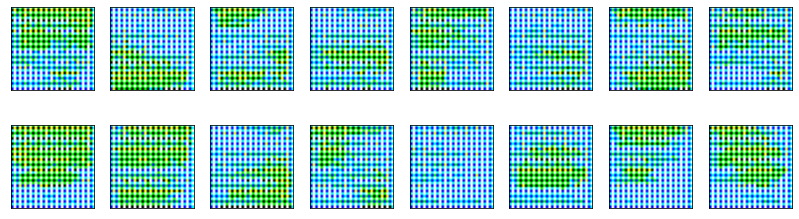

2024-08-21 17:58:06 | Epoch [19/50] | Batch 0/391 | d_loss: 0.3331 | g_loss: 19.9686
2024-08-21 17:58:42 | Epoch [19/50] | Batch 100/391 | d_loss: 0.3265 | g_loss: 18.7304
2024-08-21 17:59:17 | Epoch [19/50] | Batch 200/391 | d_loss: 0.3264 | g_loss: 17.5925
2024-08-21 17:59:54 | Epoch [19/50] | Batch 300/391 | d_loss: 0.3260 | g_loss: 16.9051


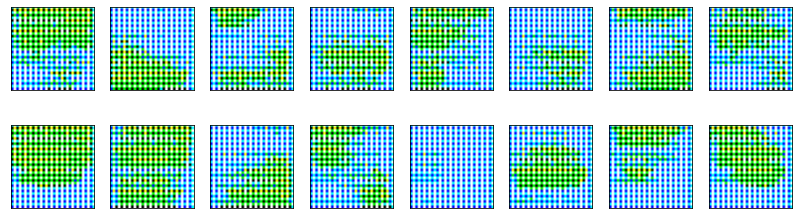

2024-08-21 18:00:31 | Epoch [20/50] | Batch 0/391 | d_loss: 0.3255 | g_loss: 16.0447
2024-08-21 18:01:08 | Epoch [20/50] | Batch 100/391 | d_loss: 0.3254 | g_loss: 15.7550
2024-08-21 18:01:45 | Epoch [20/50] | Batch 200/391 | d_loss: 0.3252 | g_loss: 15.2919
2024-08-21 18:02:21 | Epoch [20/50] | Batch 300/391 | d_loss: 0.3260 | g_loss: 14.7081


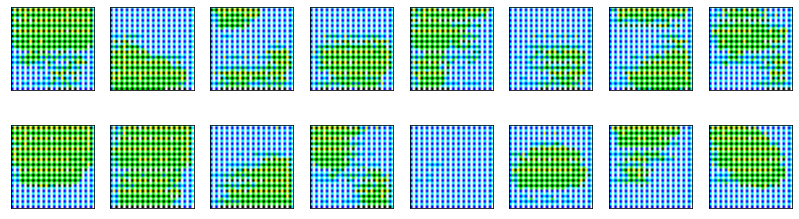

2024-08-21 18:02:57 | Epoch [21/50] | Batch 0/391 | d_loss: 0.3252 | g_loss: 14.5921
2024-08-21 18:03:37 | Epoch [21/50] | Batch 100/391 | d_loss: 0.3258 | g_loss: 14.4507
2024-08-21 18:04:14 | Epoch [21/50] | Batch 200/391 | d_loss: 0.3252 | g_loss: 14.3687
2024-08-21 18:04:49 | Epoch [21/50] | Batch 300/391 | d_loss: 0.3253 | g_loss: 14.1890


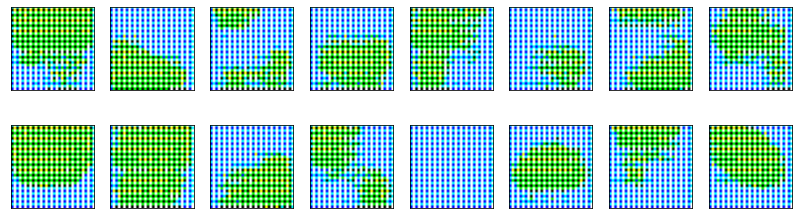

2024-08-21 18:05:26 | Epoch [22/50] | Batch 0/391 | d_loss: 0.3256 | g_loss: 14.1094
2024-08-21 18:06:04 | Epoch [22/50] | Batch 100/391 | d_loss: 0.3255 | g_loss: 14.0770
2024-08-21 18:06:40 | Epoch [22/50] | Batch 200/391 | d_loss: 0.3253 | g_loss: 14.1527
2024-08-21 18:07:16 | Epoch [22/50] | Batch 300/391 | d_loss: 0.3253 | g_loss: 14.0962


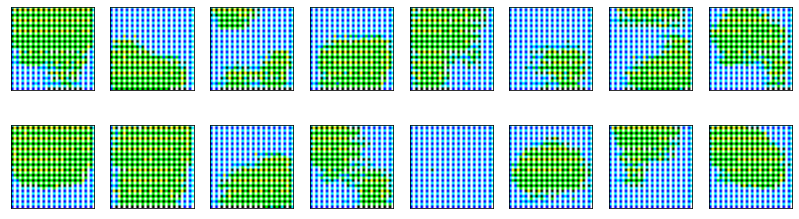

2024-08-21 18:07:52 | Epoch [23/50] | Batch 0/391 | d_loss: 0.3256 | g_loss: 13.9928
2024-08-21 18:08:26 | Epoch [23/50] | Batch 100/391 | d_loss: 0.3252 | g_loss: 13.9687
2024-08-21 18:08:59 | Epoch [23/50] | Batch 200/391 | d_loss: 0.3253 | g_loss: 14.0702
2024-08-21 18:09:31 | Epoch [23/50] | Batch 300/391 | d_loss: 0.3252 | g_loss: 14.1488


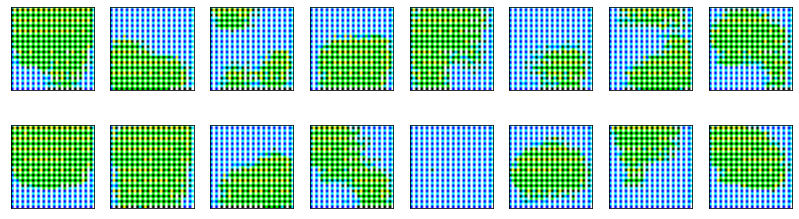

2024-08-21 18:10:06 | Epoch [24/50] | Batch 0/391 | d_loss: 0.3254 | g_loss: 14.0736
2024-08-21 18:10:40 | Epoch [24/50] | Batch 100/391 | d_loss: 0.3251 | g_loss: 14.2349
2024-08-21 18:11:12 | Epoch [24/50] | Batch 200/391 | d_loss: 0.3253 | g_loss: 14.0159
2024-08-21 18:11:45 | Epoch [24/50] | Batch 300/391 | d_loss: 0.3253 | g_loss: 14.0219


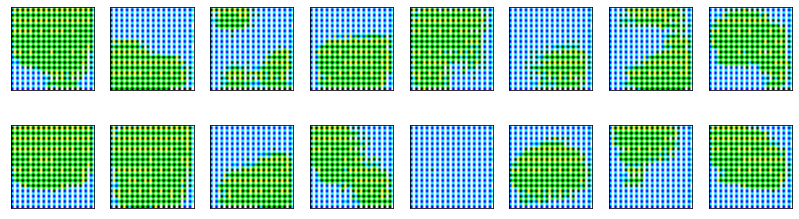

2024-08-21 18:12:19 | Epoch [25/50] | Batch 0/391 | d_loss: 0.3255 | g_loss: 14.0903
2024-08-21 18:12:52 | Epoch [25/50] | Batch 100/391 | d_loss: 0.3254 | g_loss: 14.0895
2024-08-21 18:13:25 | Epoch [25/50] | Batch 200/391 | d_loss: 0.3252 | g_loss: 14.0172
2024-08-21 18:13:58 | Epoch [25/50] | Batch 300/391 | d_loss: 0.3254 | g_loss: 13.9293


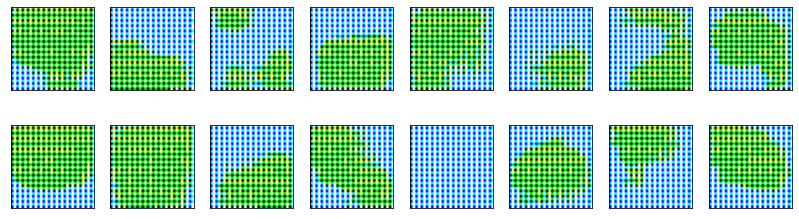

2024-08-21 18:14:31 | Epoch [26/50] | Batch 0/391 | d_loss: 0.3252 | g_loss: 13.7702
2024-08-21 18:15:04 | Epoch [26/50] | Batch 100/391 | d_loss: 0.3252 | g_loss: 13.7442
2024-08-21 18:15:37 | Epoch [26/50] | Batch 200/391 | d_loss: 0.3252 | g_loss: 13.7139
2024-08-21 18:16:09 | Epoch [26/50] | Batch 300/391 | d_loss: 0.3257 | g_loss: 13.7971


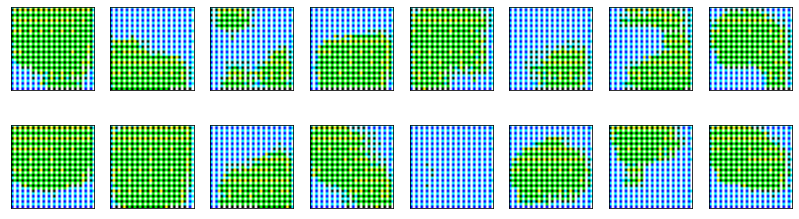

2024-08-21 18:16:45 | Epoch [27/50] | Batch 0/391 | d_loss: 0.3252 | g_loss: 13.7558
2024-08-21 18:17:18 | Epoch [27/50] | Batch 100/391 | d_loss: 0.3254 | g_loss: 13.6256
2024-08-21 18:17:54 | Epoch [27/50] | Batch 200/391 | d_loss: 0.3252 | g_loss: 13.6292
2024-08-21 18:18:28 | Epoch [27/50] | Batch 300/391 | d_loss: 0.3258 | g_loss: 13.5776


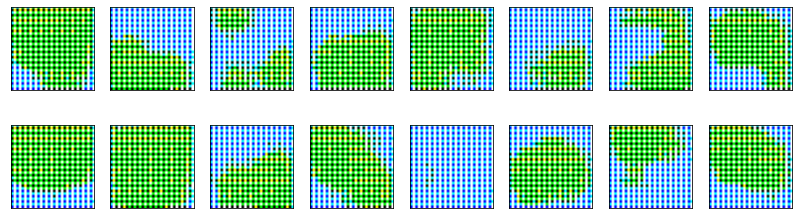

2024-08-21 18:19:07 | Epoch [28/50] | Batch 0/391 | d_loss: 0.3253 | g_loss: 13.6458
2024-08-21 18:19:44 | Epoch [28/50] | Batch 100/391 | d_loss: 0.3256 | g_loss: 13.4586
2024-08-21 18:20:18 | Epoch [28/50] | Batch 200/391 | d_loss: 0.3254 | g_loss: 13.5355
2024-08-21 18:20:53 | Epoch [28/50] | Batch 300/391 | d_loss: 0.3254 | g_loss: 13.5202


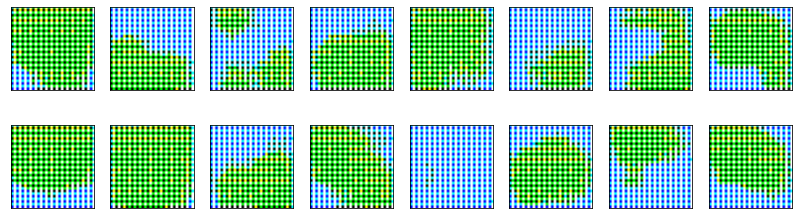

2024-08-21 18:21:29 | Epoch [29/50] | Batch 0/391 | d_loss: 0.3254 | g_loss: 13.4901
2024-08-21 18:22:00 | Epoch [29/50] | Batch 100/391 | d_loss: 0.3253 | g_loss: 13.5222
2024-08-21 18:22:34 | Epoch [29/50] | Batch 200/391 | d_loss: 0.3252 | g_loss: 13.3082
2024-08-21 18:23:07 | Epoch [29/50] | Batch 300/391 | d_loss: 0.3255 | g_loss: 13.4403


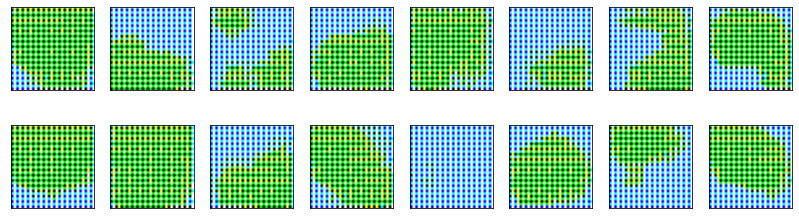

2024-08-21 18:23:41 | Epoch [30/50] | Batch 0/391 | d_loss: 0.3255 | g_loss: 13.3186
2024-08-21 18:24:14 | Epoch [30/50] | Batch 100/391 | d_loss: 0.3252 | g_loss: 13.2066
2024-08-21 18:24:47 | Epoch [30/50] | Batch 200/391 | d_loss: 0.3254 | g_loss: 13.3348
2024-08-21 18:25:21 | Epoch [30/50] | Batch 300/391 | d_loss: 0.3254 | g_loss: 13.2301


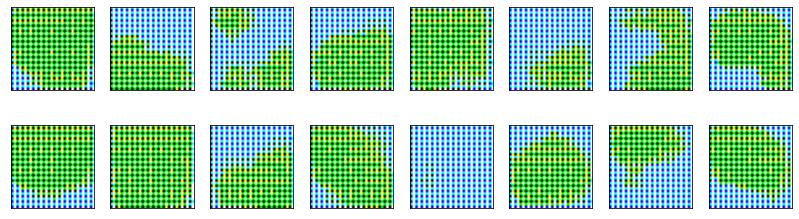

2024-08-21 18:25:56 | Epoch [31/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 13.3178
2024-08-21 18:26:32 | Epoch [31/50] | Batch 100/391 | d_loss: 0.3252 | g_loss: 13.3879
2024-08-21 18:27:05 | Epoch [31/50] | Batch 200/391 | d_loss: 0.3261 | g_loss: 13.3936
2024-08-21 18:27:38 | Epoch [31/50] | Batch 300/391 | d_loss: 0.3251 | g_loss: 13.0514


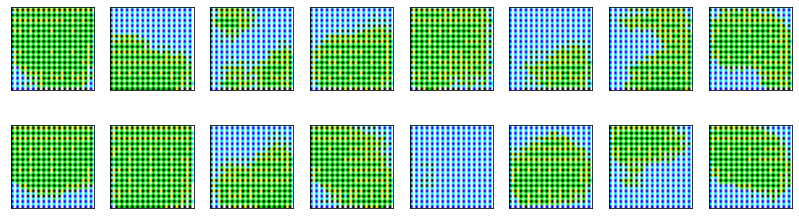

2024-08-21 18:28:13 | Epoch [32/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 13.1862
2024-08-21 18:28:46 | Epoch [32/50] | Batch 100/391 | d_loss: 0.3254 | g_loss: 13.2942
2024-08-21 18:29:20 | Epoch [32/50] | Batch 200/391 | d_loss: 0.3252 | g_loss: 13.2358
2024-08-21 18:29:53 | Epoch [32/50] | Batch 300/391 | d_loss: 0.3251 | g_loss: 13.2162


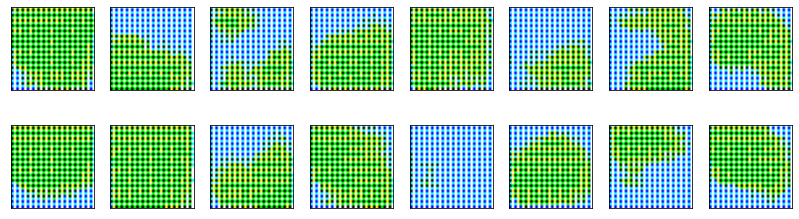

2024-08-21 18:30:27 | Epoch [33/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 12.9799
2024-08-21 18:31:01 | Epoch [33/50] | Batch 100/391 | d_loss: 0.3252 | g_loss: 13.1698
2024-08-21 18:31:36 | Epoch [33/50] | Batch 200/391 | d_loss: 0.3251 | g_loss: 13.1957
2024-08-21 18:32:13 | Epoch [33/50] | Batch 300/391 | d_loss: 0.3254 | g_loss: 13.2650


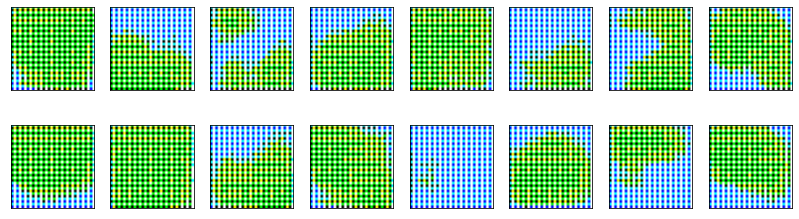

2024-08-21 18:32:48 | Epoch [34/50] | Batch 0/391 | d_loss: 0.3252 | g_loss: 13.1227
2024-08-21 18:33:21 | Epoch [34/50] | Batch 100/391 | d_loss: 0.3251 | g_loss: 13.1197
2024-08-21 18:33:54 | Epoch [34/50] | Batch 200/391 | d_loss: 0.3251 | g_loss: 13.0232
2024-08-21 18:34:27 | Epoch [34/50] | Batch 300/391 | d_loss: 0.3252 | g_loss: 13.0252


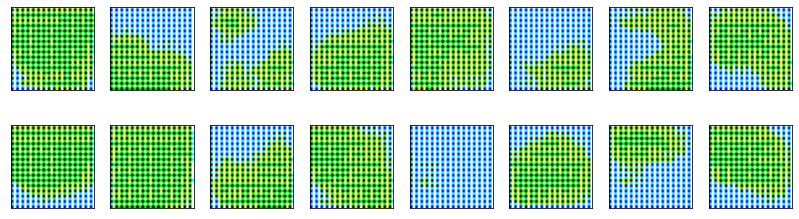

2024-08-21 18:35:04 | Epoch [35/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 13.0390
2024-08-21 18:35:37 | Epoch [35/50] | Batch 100/391 | d_loss: 0.3251 | g_loss: 13.1117
2024-08-21 18:36:11 | Epoch [35/50] | Batch 200/391 | d_loss: 0.3252 | g_loss: 13.2377
2024-08-21 18:36:43 | Epoch [35/50] | Batch 300/391 | d_loss: 0.3253 | g_loss: 13.0608


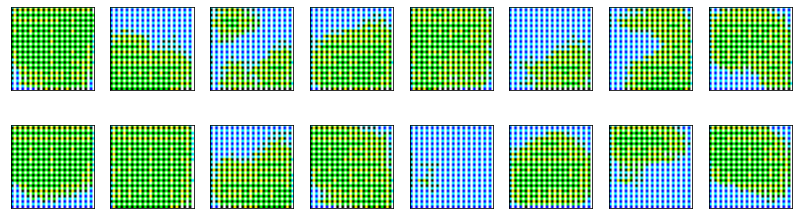

2024-08-21 18:37:17 | Epoch [36/50] | Batch 0/391 | d_loss: 0.3254 | g_loss: 13.1265
2024-08-21 18:37:51 | Epoch [36/50] | Batch 100/391 | d_loss: 0.3251 | g_loss: 13.1583
2024-08-21 18:38:24 | Epoch [36/50] | Batch 200/391 | d_loss: 0.3251 | g_loss: 13.0463
2024-08-21 18:38:58 | Epoch [36/50] | Batch 300/391 | d_loss: 0.3252 | g_loss: 13.1144


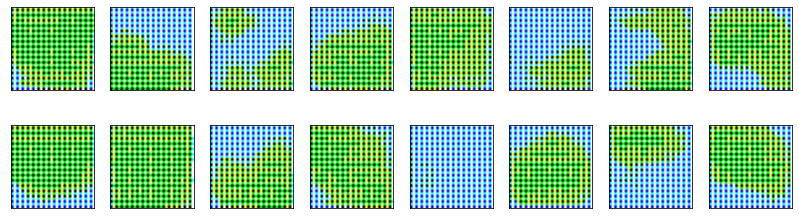

2024-08-21 18:39:36 | Epoch [37/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 13.2383
2024-08-21 18:40:14 | Epoch [37/50] | Batch 100/391 | d_loss: 0.3256 | g_loss: 13.0864
2024-08-21 18:40:52 | Epoch [37/50] | Batch 200/391 | d_loss: 0.3251 | g_loss: 13.2141
2024-08-21 18:41:30 | Epoch [37/50] | Batch 300/391 | d_loss: 0.3252 | g_loss: 13.1013


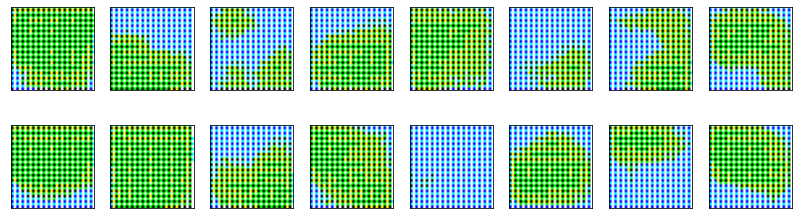

2024-08-21 18:42:08 | Epoch [38/50] | Batch 0/391 | d_loss: 0.3252 | g_loss: 13.3323
2024-08-21 18:42:45 | Epoch [38/50] | Batch 100/391 | d_loss: 0.3252 | g_loss: 13.0786
2024-08-21 18:43:22 | Epoch [38/50] | Batch 200/391 | d_loss: 0.3261 | g_loss: 12.8948
2024-08-21 18:43:59 | Epoch [38/50] | Batch 300/391 | d_loss: 0.3252 | g_loss: 13.0775


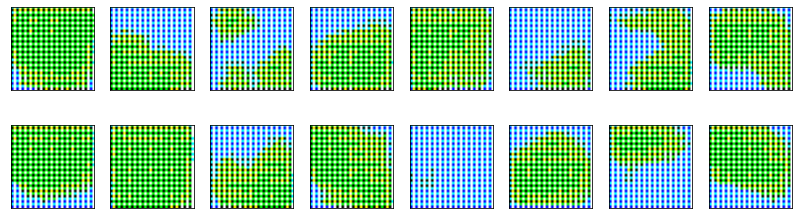

2024-08-21 18:44:37 | Epoch [39/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 13.1255
2024-08-21 18:45:14 | Epoch [39/50] | Batch 100/391 | d_loss: 0.3251 | g_loss: 13.3033
2024-08-21 18:45:50 | Epoch [39/50] | Batch 200/391 | d_loss: 0.3251 | g_loss: 12.9095
2024-08-21 18:46:26 | Epoch [39/50] | Batch 300/391 | d_loss: 0.3251 | g_loss: 13.2407


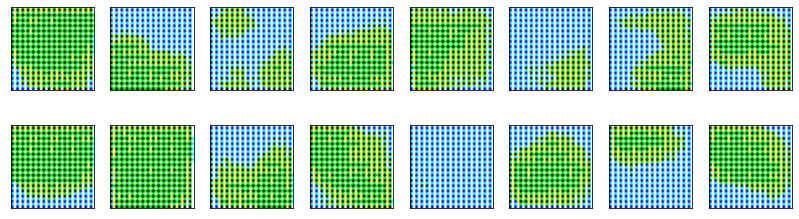

2024-08-21 18:47:04 | Epoch [40/50] | Batch 0/391 | d_loss: 0.3252 | g_loss: 13.3544
2024-08-21 18:47:41 | Epoch [40/50] | Batch 100/391 | d_loss: 0.3253 | g_loss: 13.3481
2024-08-21 18:48:16 | Epoch [40/50] | Batch 200/391 | d_loss: 0.3252 | g_loss: 13.2684
2024-08-21 18:48:53 | Epoch [40/50] | Batch 300/391 | d_loss: 0.3252 | g_loss: 13.3451


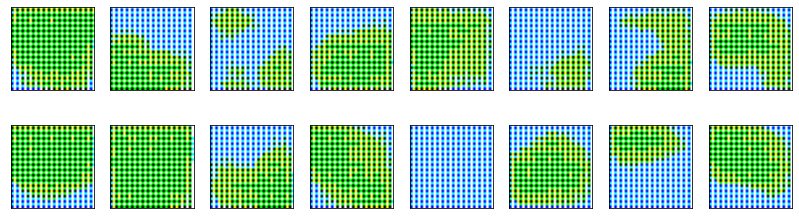

2024-08-21 18:49:30 | Epoch [41/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 12.9402
2024-08-21 18:50:08 | Epoch [41/50] | Batch 100/391 | d_loss: 0.3251 | g_loss: 13.0872
2024-08-21 18:50:46 | Epoch [41/50] | Batch 200/391 | d_loss: 0.3255 | g_loss: 13.2699
2024-08-21 18:51:23 | Epoch [41/50] | Batch 300/391 | d_loss: 0.3251 | g_loss: 13.2833


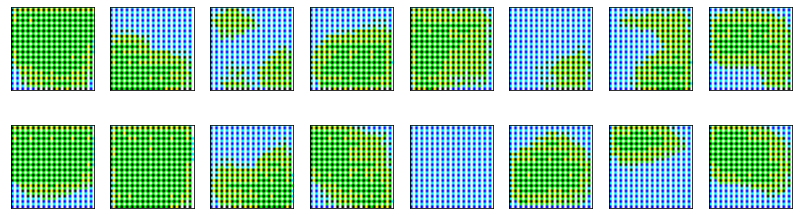

2024-08-21 18:52:01 | Epoch [42/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 13.1653
2024-08-21 18:52:39 | Epoch [42/50] | Batch 100/391 | d_loss: 0.3253 | g_loss: 13.3436
2024-08-21 18:53:17 | Epoch [42/50] | Batch 200/391 | d_loss: 0.3253 | g_loss: 13.3011
2024-08-21 18:53:55 | Epoch [42/50] | Batch 300/391 | d_loss: 0.3251 | g_loss: 13.4316


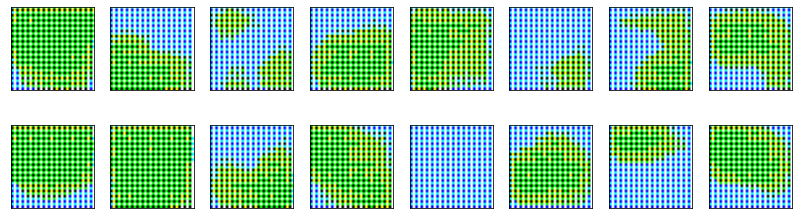

2024-08-21 18:54:32 | Epoch [43/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 12.9839
2024-08-21 18:55:08 | Epoch [43/50] | Batch 100/391 | d_loss: 0.3251 | g_loss: 13.3305
2024-08-21 18:55:41 | Epoch [43/50] | Batch 200/391 | d_loss: 0.3251 | g_loss: 13.5093
2024-08-21 18:56:13 | Epoch [43/50] | Batch 300/391 | d_loss: 0.3251 | g_loss: 13.4876


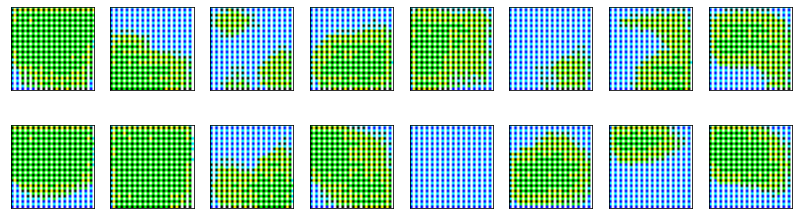

2024-08-21 18:56:48 | Epoch [44/50] | Batch 0/391 | d_loss: 0.3253 | g_loss: 13.4231
2024-08-21 18:57:22 | Epoch [44/50] | Batch 100/391 | d_loss: 0.3251 | g_loss: 13.0676
2024-08-21 18:57:54 | Epoch [44/50] | Batch 200/391 | d_loss: 0.3253 | g_loss: 13.4147
2024-08-21 18:58:27 | Epoch [44/50] | Batch 300/391 | d_loss: 0.3251 | g_loss: 13.3728


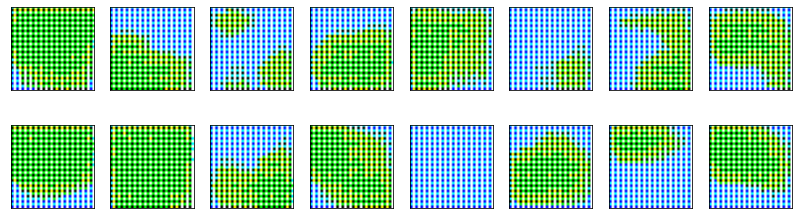

2024-08-21 18:59:02 | Epoch [45/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 13.3215
2024-08-21 18:59:34 | Epoch [45/50] | Batch 100/391 | d_loss: 0.3252 | g_loss: 13.5186
2024-08-21 19:00:07 | Epoch [45/50] | Batch 200/391 | d_loss: 0.3252 | g_loss: 13.2348
2024-08-21 19:00:41 | Epoch [45/50] | Batch 300/391 | d_loss: 0.3252 | g_loss: 13.4628


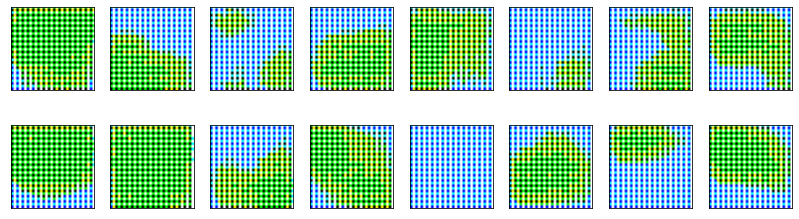

2024-08-21 19:01:16 | Epoch [46/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 13.3142
2024-08-21 19:01:49 | Epoch [46/50] | Batch 100/391 | d_loss: 0.3251 | g_loss: 13.5085
2024-08-21 19:02:23 | Epoch [46/50] | Batch 200/391 | d_loss: 0.3251 | g_loss: 13.6164
2024-08-21 19:02:56 | Epoch [46/50] | Batch 300/391 | d_loss: 0.3251 | g_loss: 13.4250


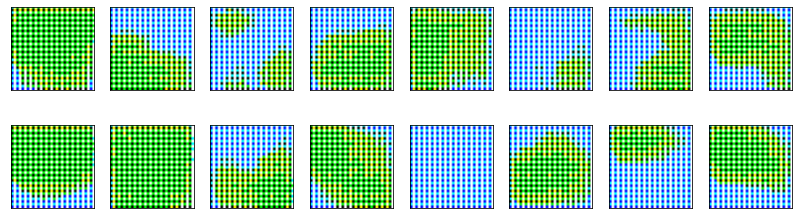

2024-08-21 19:03:33 | Epoch [47/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 13.5742
2024-08-21 19:04:06 | Epoch [47/50] | Batch 100/391 | d_loss: 0.3251 | g_loss: 13.5609
2024-08-21 19:04:38 | Epoch [47/50] | Batch 200/391 | d_loss: 0.3252 | g_loss: 13.3624
2024-08-21 19:05:11 | Epoch [47/50] | Batch 300/391 | d_loss: 0.3251 | g_loss: 12.9018


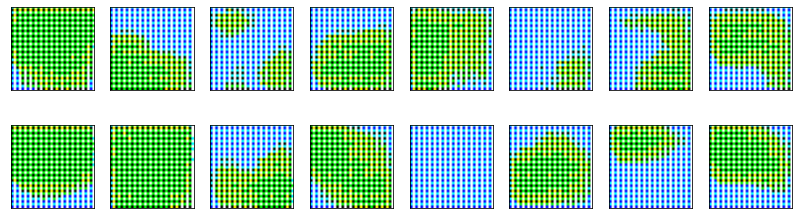

2024-08-21 19:05:46 | Epoch [48/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 13.3592
2024-08-21 19:06:22 | Epoch [48/50] | Batch 100/391 | d_loss: 0.3251 | g_loss: 13.3603
2024-08-21 19:06:57 | Epoch [48/50] | Batch 200/391 | d_loss: 0.3251 | g_loss: 13.6641
2024-08-21 19:07:30 | Epoch [48/50] | Batch 300/391 | d_loss: 0.3251 | g_loss: 13.5285


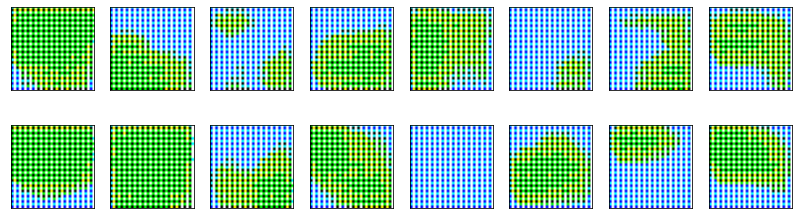

2024-08-21 19:08:05 | Epoch [49/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 13.7067
2024-08-21 19:08:39 | Epoch [49/50] | Batch 100/391 | d_loss: 0.3251 | g_loss: 13.6608
2024-08-21 19:09:13 | Epoch [49/50] | Batch 200/391 | d_loss: 0.3251 | g_loss: 13.3809
2024-08-21 19:09:45 | Epoch [49/50] | Batch 300/391 | d_loss: 0.3254 | g_loss: 13.5265


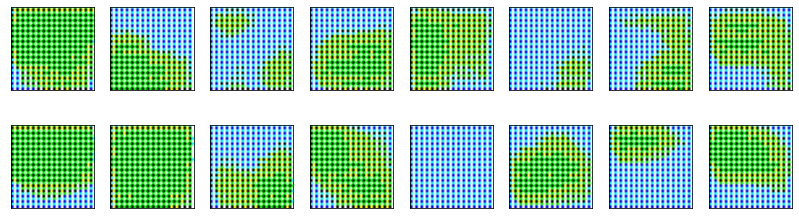

2024-08-21 19:10:20 | Epoch [50/50] | Batch 0/391 | d_loss: 0.3251 | g_loss: 13.7442
2024-08-21 19:10:53 | Epoch [50/50] | Batch 100/391 | d_loss: 0.3251 | g_loss: 13.4062
2024-08-21 19:11:25 | Epoch [50/50] | Batch 200/391 | d_loss: 0.3251 | g_loss: 13.6640
2024-08-21 19:12:02 | Epoch [50/50] | Batch 300/391 | d_loss: 0.3251 | g_loss: 13.5787


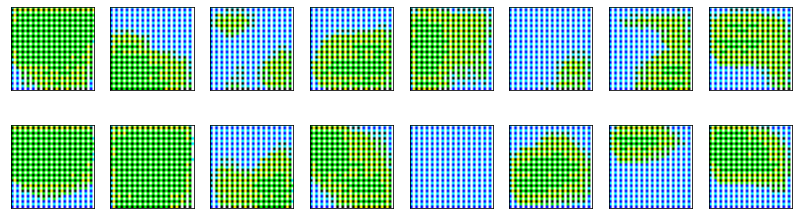

In [18]:
# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 100

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size, 1, 1))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        d_optimizer.zero_grad()
        
        # 1. Compute the discriminator loss on real, training images
        if train_on_gpu:
            real_images = real_images.cuda()
        
        d_real_output = D(real_images)
        d_real_loss = real_loss(d_real_output, smooth=True)
        
        # 2. Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size, 1, 1))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # 3. Compute the discriminator loss on fake, generated images
        d_fake_output = D(fake_images.detach())
        d_fake_loss = fake_loss(d_fake_output)
        
        # 4. Add up real and fake loss
        d_loss = d_real_loss + d_fake_loss
        
        # 5. Perform backpropagation + an optimization step to update the discriminator's weights
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        d_optimizer.zero_grad()
        
        # 1. Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size, 1, 1))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # 2. Compute the discriminator loss on fake images, using flipped labels!
        g_output = D(fake_images)
        g_loss = real_loss(g_output) # use real loss to flip labels
        
        # 3. Perform backpropagation + an optimization step to update the generator's weights
        g_loss.backward()
        g_optimizer.step()
        
        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{num_epochs}] | Batch {batch_i}/{len(train_loader)} | d_loss: {d_loss.item():.4f} | g_loss: {g_loss.item():.4f}')
    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    view_samples(-1, samples)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

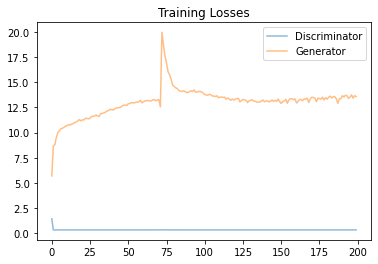

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()